# Bonne pratique

## Les imports

## Les fonctions

## 

# Ce projet fonctionne avec les versions des package suivants:

- matplotlib==3.9.0
- pandas==2.2.2
- seaborn==0.13.2
- missingno==0.5.2
- scikit-learn==1.5.1

## The Data
This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world. The data is meant to be free to the public to help users decode food labels, and make better food choices in general. The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.<br/>
Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

Depuis le 26 juin 2024, la méthode de calcul du Nutri-Score a été mise à jour on peu en trouver les détails dans ce document:
- https://www.santepubliquefrance.fr/content/download/150262/file/FAQ-updatedAlgo-FR_20231222.pdf

En utilisant ce document, on peut selectionner les colonnes à conserver les plus pertinente.

In [5]:
import tkinter as tk
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from tkinter import filedialog
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# from tqdm import tqdm
# from sklearn.neighbors import KNeighborsClassifier
# from scipy import stats


# Nettoyer et Filtrer les Features et Produits

## 1.1. Collecter et Préparer les Données Brutes
### 1. Charger les données dans un DataFrame Pandas

In [6]:
def project_init():
    global original_data, target
    display(HTML("<h1 style='color: white'>Open Food Facts</h1>"))
    print('Initialisation du projet...', end='\r')
    filepath ='datas/openfoodfacts.csv'
    target ='nutrition_grade_fr'
    original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
    print(' '*len('Initialisation du projet...'), end='\r')
    print('Projet chargé')
    return filepath, target, original_data

In [7]:
filepath, target, original_data= project_init()

Projet chargé              


In [8]:
def select_file():
    print("charger le nouveau fichier")
    root =tk.Tk()
    root.withdraw()

    filepath = filedialog.askopenfilename(
        title="Choisissez votre fichier csv",
        filetypes=(("Fichiers CSV","*.csv"), ("Tous les fichiers","*.*"))
    )
    print(' '*len("charger le nouveau fichier"),end='\r')
    print("chargement en cours...")
    root.destroy()

    if filepath:
        try:
            original_data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
            print(' '*len("chargement en cours..."),end='\r')
            print(f"Fichier chargé avec succès depuis le chemin: {filepath}")
            return original_data
        except Exeption as e:
            print("Erreur lors du chargement du fichier:",e)
    else:
        print("Aucun fichier sélectionné.")

In [9]:
def select_columns():
    negative_elements =['energy_100g','saturated-fat_100g','sugars_100g','salt_100g']
    positive_elements=['proteins_100g','fiber_100g','fruits-vegetables-nuts_100g']
    columns_to_keep =[target,'nutrition-score-fr_100g']
    if len(negative_elements)>1:
        for ne in negative_elements:
            columns_to_keep.append(ne)
    if len(positive_elements)>1:
        for pe in positive_elements:
            columns_to_keep.append(pe)
    return columns_to_keep,negative_elements,positive_elements

In [10]:
# Nettoie le dataset des valeur nulles de la cible
def clean_target(data, target):
    print(f'⏳ Nettoyage des données nulles de la cible {target}',end='\r')
    before_cleaning = data[target].count()
    data=data.dropna(subset=[target])
    after_cleaning = data[target].count()
    print(f' '*len(f'⏳ Nettoyage des données nulles de la cible {target}'),end='\r')
    print(f'✅ Données nulles de la cible {target} nettoyées')

    return data, pd.DataFrame({"Avant nettoyage:": [before_cleaning], "Après nettoyage": [after_cleaning] })

In [11]:
def clean_duplicate(data):
    print(f"⏳ Nettoyage des doublons de la colonne 'code'",end='\r')
    before_cleaning = data.shape[0]
    data = data.drop_duplicates()
    print(f' '*len("⏳ Nettoyage des doublons de la colonne 'code'"),end='\r')
    after_cleaning = data.shape[0]
    print(f"✅ Doublons de la colonne 'code' nettoyés")
    return data,pd.DataFrame({"Avant nettoyage:": [before_cleaning], "Après nettoyage": [after_cleaning] })

In [145]:
def filter_columns(data):
    # Sélectionne les colonnes se terminant par '_100g'
    columns_to_filter = [col for col in data.columns if col.endswith('_100g')]
    if 'nutrition-score-uk_100g' in columns_to_filter:
        columns_to_filter.remove('nutrition-score-uk_100g')
    # print(f'filter_columns {columns_to_filter}')
    # if target not in columns_to_filter:
    #     columns_to_filter.append(target)
    # Filtrer les colonnes qui ont moins de 50% de valeurs NaN
    threshold = len(data) * 0.62
    filtered_data = data[columns_to_filter].dropna(axis=1, thresh=threshold)
    print(f'Features ayant plus de {(threshold/ len(data)*100)}% de données:\n')
    # print(f'{filtered_data.columns}')
    return filtered_data

In [13]:
def split_features(data):
    quantitative_features = data.select_dtypes(include=['float64','int64'])
    qualitative_features = data.select_dtypes(include=['object'])
    return quantitative_features,qualitative_features

In [127]:
def boxplot_IQR(filtered_data, quantitative_features, IQR=False):
    # Choix du titre en fonction de l'état IQR
    
    if IQR:
        print("Boxplot Après IQR")
    else:
        print("Boxplot AVANT IQR")

    num_features = len(filtered_data.columns)
    cols_per_row = 3
    num_rows = (num_features // cols_per_row) + (num_features % cols_per_row > 0)

    fig,axes= plt.subplots(num_rows, cols_per_row, figsize=(18, num_rows *6))
    axes = axes.flatten()
    # Si une seule colonne est présente, on ajuste le comportement de axes pour éviter les erreurs
    if num_features == 1:
        axes = [axes]

    # Création des boxplots pour chaque variable quantitative
    for i, col in enumerate(filtered_data.columns):
        # print(f'{col} {filtered_data[col].max()}')
        sns.boxplot(x=filtered_data[col], ax=axes[i])
        axes[i].set_title(f'Boxplot: {col}', fontsize=12)
        axes[i].set_xlabel(col)
    
    # Masquer les axes en trop (les sous-graphiques vides)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustement de l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.show()

In [112]:
def impossible_value(filtered_data,quantitative_features):
    data= filtered_data.copy()
    for col in quantitative_features.columns:
        if col in ['energy_100g']:
               data[col] = data[col].apply(lambda x: x if 0 <= x else np.nan)
        #      print('C\'est ebergy qui te parles')
        elif col in ['nutrition-score-fr_100g','nutrition-score-uk_100g']:
               data[col] = data[col].apply(lambda x: x if -15 <= x <= 40 else np.nan)
        else:
            data[col] = data[col].apply(lambda x: x if 0 <= x <= 100 else np.nan)
    return data

In [120]:
def remove_outliers(filtered_data, quantitative_features):
    data = filtered_data.copy()  # Faire une copie des données filtrées pour la manipulation
    # print(data.columns)
    # print(filtered_data.columns)
    for col in quantitative_features.columns:
        # print(col)
        # Calcul des quartiles et de l'IQR en ignorant les NaN
        Q1 = filtered_data[col].quantile(0.25, interpolation='midpoint')
        Q3 = filtered_data[col].quantile(0.75, interpolation='midpoint')
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        # print(f'maximum de {col} {filtered_data[col].max()} upper -->{upper_limit}')
        # print(f'min de {col} {filtered_data[col].min()} Lower --> {lower_limit}')

        # data = data[(data[col] >= lower_limit) & (data[col] <= upper_limit)]
        data[col] = data[col].mask((data[col] <= lower_limit) | (data[col] >= upper_limit), np.nan)
        # print(f"Data size after removing outliers from {col}: {data.shape[0]}")
    return data

Pourquoi un model de regression?
model de regression = predit un chiffre (Prix de maison...)
model de classification = predit un classe (un chat ou un chien)
clusterisation = model non superviser et il se demerde

In [17]:
def find_best_k(data_cleaned,quantitative_features):

    print('Démarrage calcul best_n pour knn imputation...',end='\r')
    df=data_cleaned.copy()
    # print(msno.matrix(df))

    missing_before = df[quantitative_features.columns].isna().sum()

         
    knn_target = 'nutrition-score-fr_100g'
    for col in quantitative_features.columns:
        df[col]=pd.to_numeric(df[col],errors='coerce')
    # print(f'numericConversion\n{df[quantitative_features.columns].isna().sum()}')
    non_numeric_values = data_cleaned['energy_100g'][~data_cleaned['energy_100g'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()]

    best_n = 0
    best_score = np.inf
    model = LinearRegression()

    df_to_impute = df[quantitative_features.columns]
    # df_to_impute = df[df[target] != np.nan]
    
    for n in range(1, 10):
        knn_imputer = KNNImputer(n_neighbors=n)
        df_imputed = knn_imputer.fit_transform(df_to_impute) #! NO EMPTY TARGETS
        
        df_imputed = pd.DataFrame(df_imputed, columns=quantitative_features.columns) #! array to df
    
        X = df_imputed.drop(columns=[knn_target]) #! X = all sauf target
        y = df_imputed[knn_target] #! y = target only
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #! convention
        
        #! tjs fit, predict
        
        model.fit(X_train, y_train) #! apprend col + trget
        y_pred = model.predict(X_test) #! se demerde avec col pour trouver target
        mse = mean_squared_error(y_test, y_pred) #! compare target predit avec target reel
        if n ==1:
            print(' '*len('Démarrage calcul best_n pour knn imputation...'),end='\r')
        print(f"mse: {mse} with n={n}")
        if  mse < best_score:
            best_score = mse
            best_n = n
            print (f"new best mse: {mse} with n={n}")
    print(f"Final best mse={best_score} et Final best n={best_n}")        
    
    return best_n #! dataset complet imputé

PRend tout ton df
Vire tout les nutriscore_100g
Salt a 0 ça merde... 
ns corr= Energy, gras sat, sugar, sel

In [18]:
def knn_impute(df,best_n):
    print('Demarrage imputation sur dataset initial')
    # columns_to_keep,_,_=select_columns()
    # print(df.columns)
    columns_to_impute = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    knn_imputer = KNNImputer(n_neighbors=best_n) #! reimpute avec le meilleur n
    
    df_imputed = knn_imputer.fit_transform(df[columns_to_impute]) #! sur df COMPLET
    
    df_imputed = pd.DataFrame(df_imputed, columns=columns_to_impute)

    df[columns_to_impute]= df_imputed

    print(' '*len('Demarrage imputation sur dataset originel'),end='\r')
    print('✅ imputation sur dataset initial fait')
    return df

### Map nutrition score vers lettre
Les seuil des différents score ont été trouvé sur : https://fr.wikipedia.org/wiki/Nutri-score

In [19]:
def map_nutrition_grade(data):
    print('Démarrage nutrition grade map',end='\r')
    def score_to_letter(score):
        if pd.isna(score):
            return None
        if -15<= score <= -2:
            return 'a'
        elif -1<= score <= 3:
            return 'b'
        elif 4 <= score <= 11:
            return 'c'
        elif 12 <= score <= 16:
            return 'd'
        else:
            return 'e'
    print(' '*len('Démarrage nutrition grade map'),end='\r')
    print('✅ Démarrage nutrition grade map fait')
    data['nutrition_grade_fr'] = data['nutrition-score-fr_100g'].apply(score_to_letter)
    return data

In [20]:
data,comparison_table=clean_target(original_data,target)


✅ Données nulles de la cible nutrition_grade_fr nettoyées    


In [146]:
def find_best_n():
    print('Nettoyage et imputation du dataset')
    data = original_data.copy() # Travil sur une copie du dataset
    # print(f'shape: {data.shape}')
    # print(f'Info:\n')
    # data.info()
    # print(f'Describe:\n {data.describe()}')
    df_clean_target,comparison_table=clean_target(data, target) # Nettoie le dataSet des valeurs nulles sur la cible
    print(comparison_table)
    msno.matrix(df_clean_target)

    df_filter_columns= filter_columns(df_clean_target) # Selectionne les colonnes ayant au moins 50% de valeurs non nulles
    print(df_filter_columns.columns)
    df_clean_duplicate,table=clean_duplicate(df_filter_columns) # Nettoie les doublon du dataset sans valeur nulles sur la cible
    print(table)
    msno.matrix(df_clean_duplicate)

    # # df_filter_columns=df_filter_columns.dropna()

    quantitative_features,_=split_features(df_clean_duplicate)
    boxplot_IQR(df_clean_duplicate, quantitative_features, IQR=False)
    df_impossible_value = impossible_value(df_clean_duplicate,quantitative_features)
    
    df_remove_outliers= remove_outliers(df_impossible_value,quantitative_features) # Traitement des outliers pour le calcul du best K sur le dataset filtré
    # # df_filter_columns= filter_columns(df_remove_outliers)

    # # filtered_data= impossible_value(filtered_data,quantitative_features) # On retire les valeurs impossible du dataset filtré

    boxplot_IQR(df_remove_outliers,quantitative_features ,IQR=True)
    # msno.matrix(df_remove_outliers)

    best_n=find_best_k(df_remove_outliers,quantitative_features) # Calcul le best K pour l'imputation du KNN
    print('✅ Nettoyage et calcul du best n terminé')
    return best_n
    # return  data

Nettoyage et imputation du dataset
✅ Données nulles de la cible nutrition_grade_fr nettoyées    
   Avant nettoyage:  Après nettoyage
0            221210           221210
Features ayant plus de 62.000000000000014% de données:

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')
✅ Doublons de la colonne 'code' nettoyés     
   Avant nettoyage:  Après nettoyage
0            221210           164962
Boxplot AVANT IQR


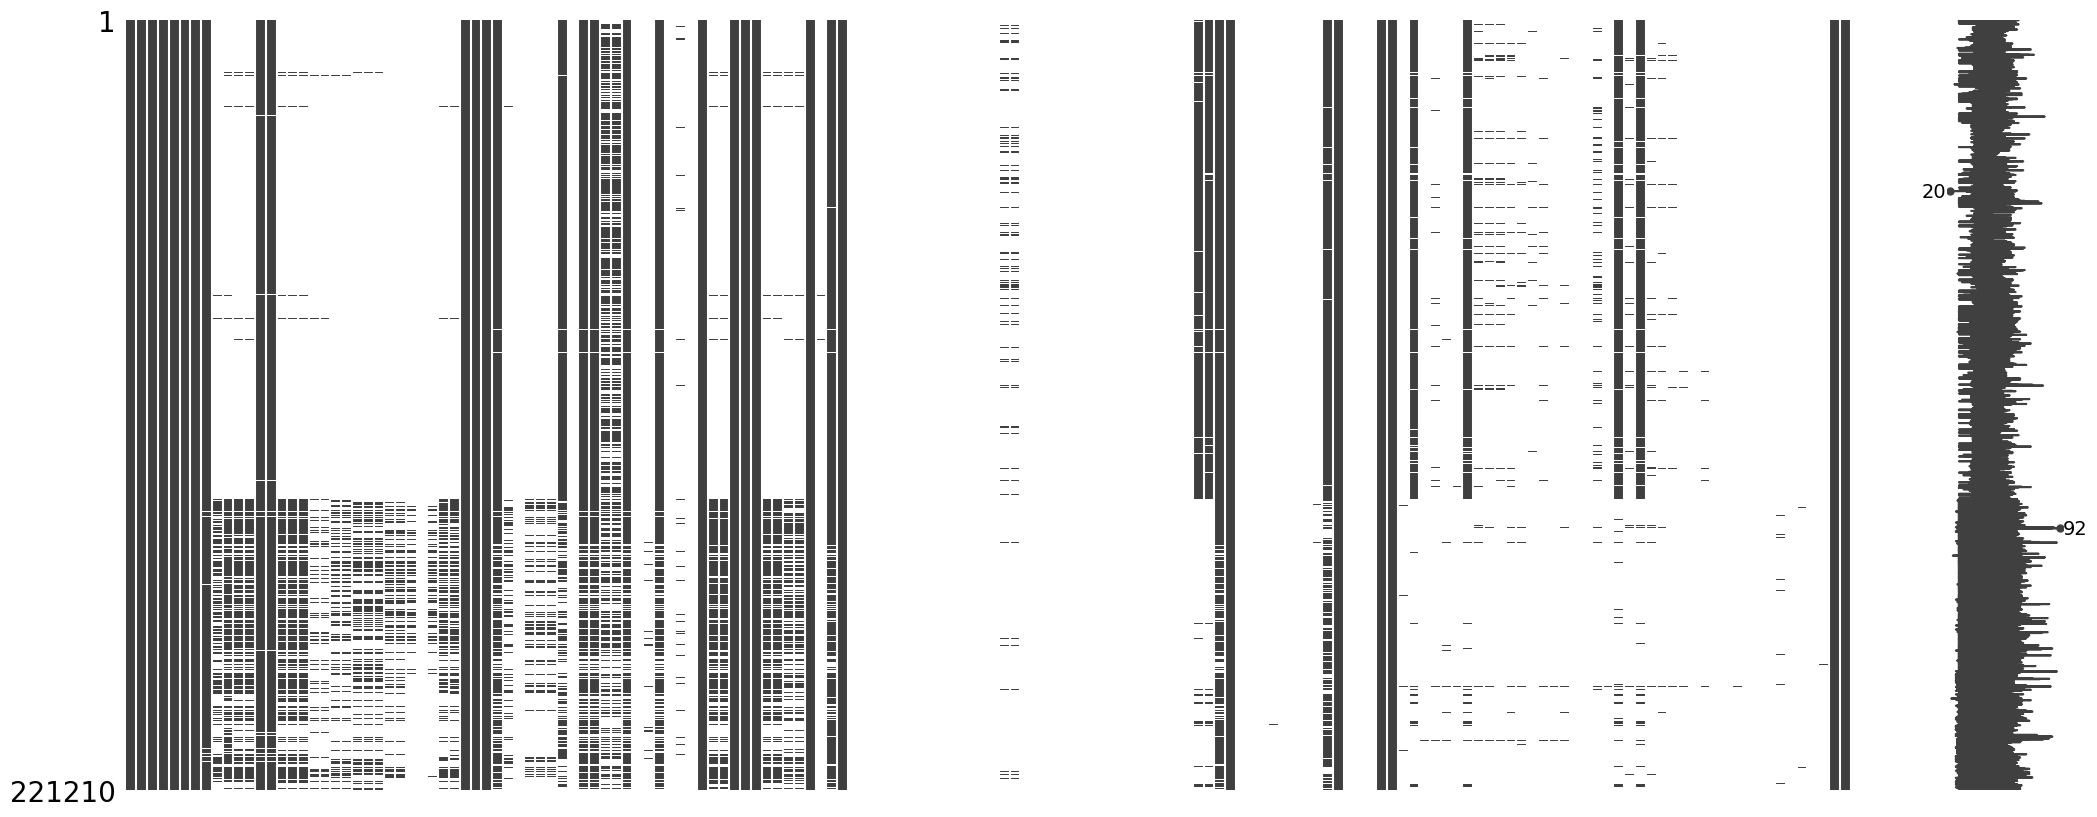

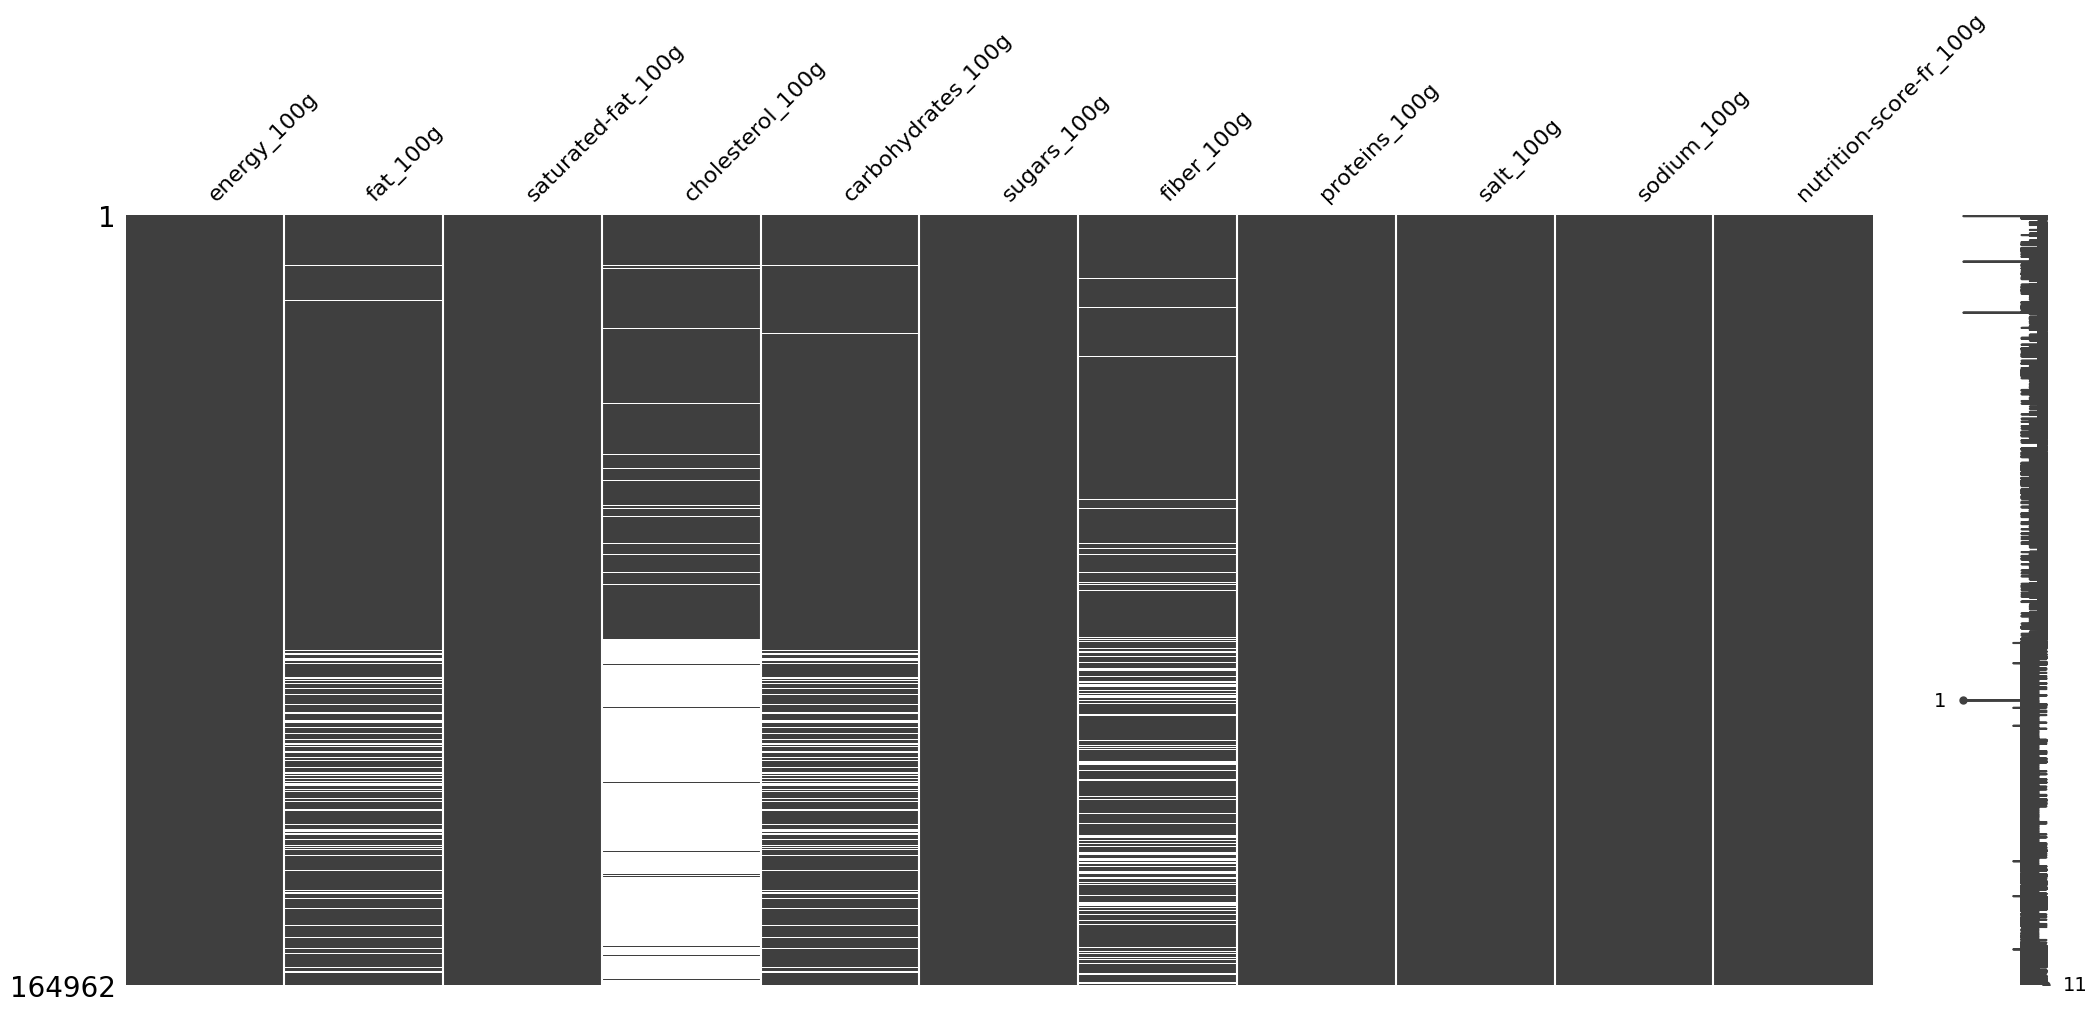

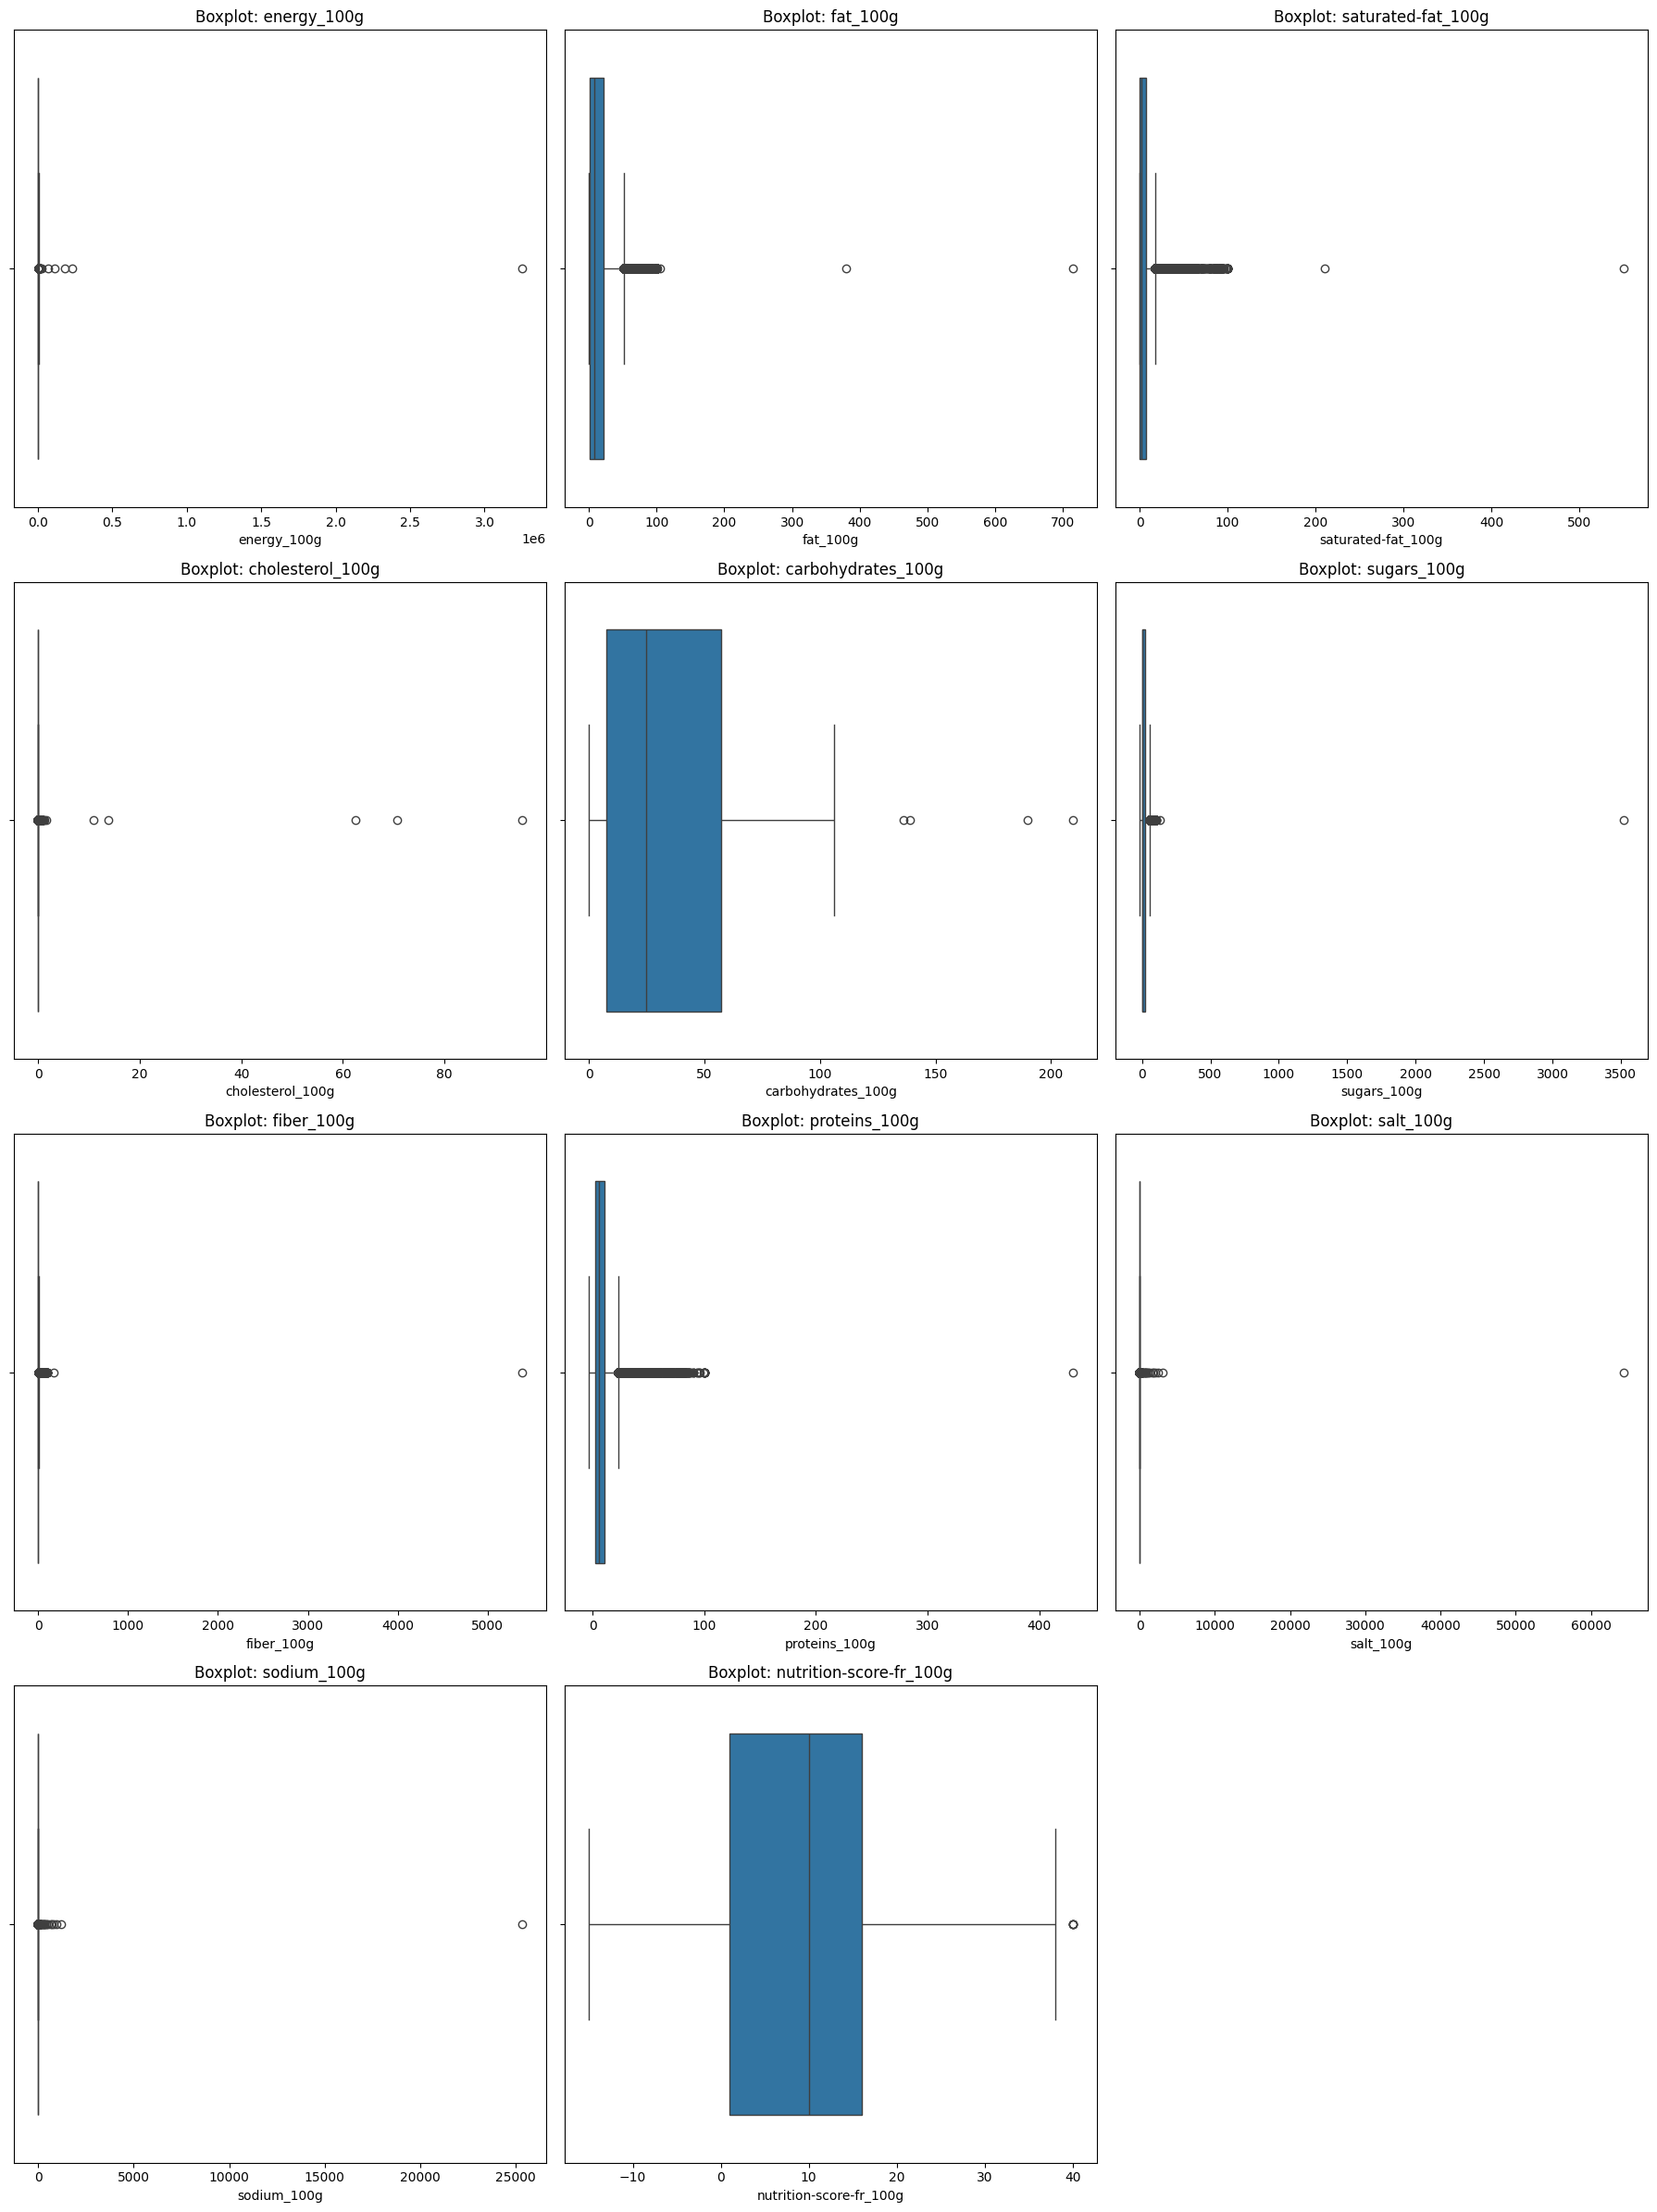

Boxplot Après IQR


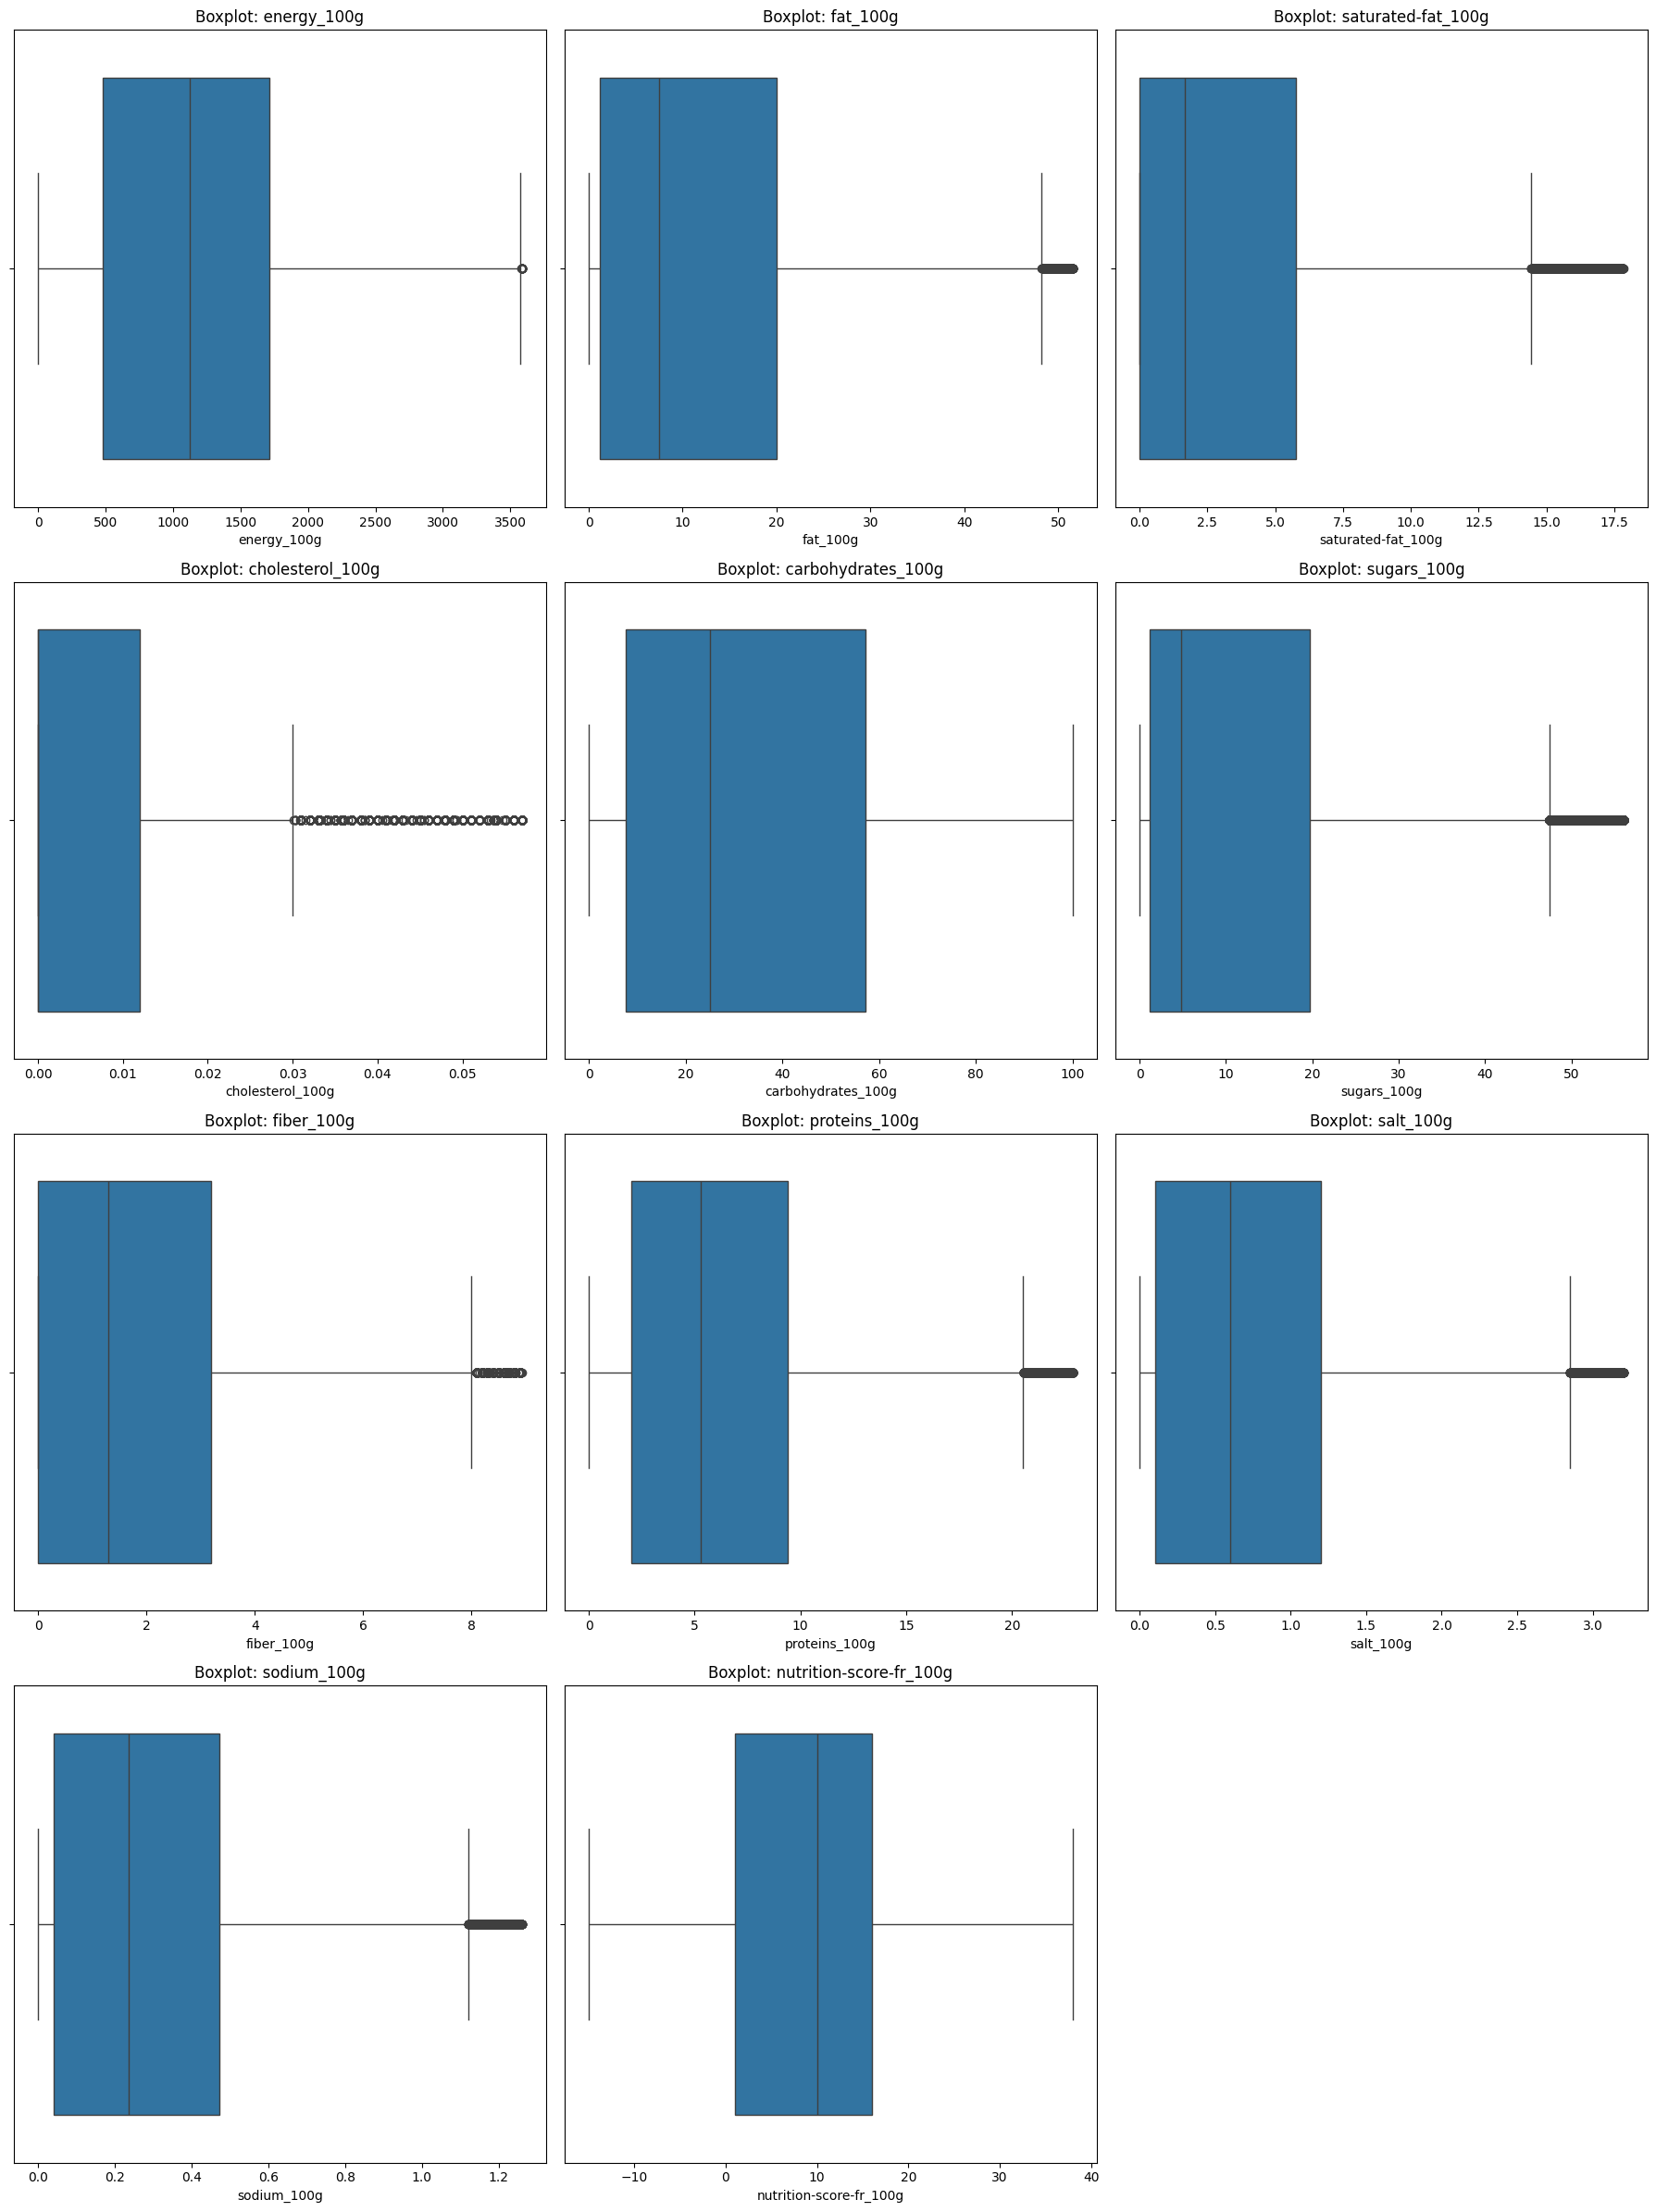

mse: 13.893567165110944 with n=1              
new best mse: 13.893567165110944 with n=1
mse: 12.8628503544044 with n=2
new best mse: 12.8628503544044 with n=2
mse: 12.375778832956364 with n=3
new best mse: 12.375778832956364 with n=3
mse: 12.189793057714697 with n=4
new best mse: 12.189793057714697 with n=4
mse: 12.026799542906181 with n=5
new best mse: 12.026799542906181 with n=5
mse: 11.937608847042757 with n=6
new best mse: 11.937608847042757 with n=6
mse: 11.858604347201283 with n=7
new best mse: 11.858604347201283 with n=7
mse: 11.812900873305756 with n=8
new best mse: 11.812900873305756 with n=8
mse: 11.792170889606455 with n=9
new best mse: 11.792170889606455 with n=9
Final best mse=11.792170889606455 et Final best n=9
✅ Nettoyage et calcul du best n terminé


In [147]:
best_n = find_best_n()

In [240]:
quantitative_features,_=split_features(original_data)
data= impossible_value(original_data,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite

In [241]:
target

'nutrition_grade_fr'

In [242]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

In [309]:
# Appel à la fonction filter_columns
data_filtered = filter_columns(original_data)
quantitative_features,_=split_features(data_filtered)
data_filtered= impossible_value(data_filtered,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite
data_filtered=remove_outliers(data_filtered,quantitative_features)
# Ajouter la colonne 'target' si elle n'est pas déjà dans le DataFrame
if target not in data_filtered.columns:
    data_filtered[target] = data[target]

# Afficher les colonnes
print(data_filtered.columns)

Features ayant plus de 62.0% de données:

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr'],
      dtype='object')


In [311]:
data_filtered.shape

(320772, 11)

In [312]:
df=knn_impute(data_filtered,best_n) #imputation sur l'ensemble du dataset

Demarrage imputation sur dataset initial
✅ imputation sur dataset initial fait    


In [313]:
df=map_nutrition_grade(df) # Mappage du nutrition_grade en fonction du df imputé

✅ Démarrage nutrition grade map fait


In [314]:
df.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr'],
      dtype='object')

In [315]:
df['nutrition_grade_fr'].value_counts().sum()

np.int64(320772)

In [23]:
# def impute(best_n):
#     quantitative_features,_=split_features(original_data)
#     data= impossible_value(original_data,quantitative_features) # On remplace les valeurs impossible par NaN du dataset complet pour faire les imputation ensuite
#     df=knn_impute(data,best_n,quantitative_features) #imputation sur l'ensemble du dataset
#     map_nutrition_grade(df) # Mappage du nutrition_grade en fonction du df imputé

## Analyse de la distribution des variables quantitatives

### Graph de distribtution des variables quantitatives

In [316]:
def analyze_distribution(data,quantitative_features):
    num_cols = len(quantitative_features.columns)

    cols_per_row = 2
    num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    fig,axes= plt.subplots(num_rows, cols_per_row, figsize=(18, num_rows *6))
    axes = axes.flatten()

    for i, col in enumerate(quantitative_features.columns):

        sns.histplot(data[col].dropna(),kde=True, ax =axes[i])
        axes[i].set_title(f'Distribution of {col}', fontsize=16)
        axes[i].set_xlabel(col,fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)

        # # Calculating basic metrics
        # mean_value = data[col].mean()
        # median_value = data[col].median()
        # quantiles = data[col].quantile([0.25, 0.5, 0.75])
        
        # print(f'{col} - Mean: {mean_value}, Median: {median_value}')
        # print(f'Quantiles:')
        # print(quantiles)
        # print('---' * 10)

    if num_cols <len(axes):
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Calcul de la dispertion en fonction de l'écart-type

In [317]:
def calculate_metrics(data,quantitative_features):
    metrics={}

    for col in quantitative_features.columns:
        std_dev =data[col].std() # Calcul de l'ecart type

        if std_dev > data[col].mean() * 0.5:
            central_tendency = data[col].median()
            measure= "mediane"
        else:
            central_tendency = data[col].mean()
            measure= "moyenne"
        metrics[col]={
            "Mesure choisie": measure,
            "Valeur": central_tendency,
            "Écart-type": std_dev
        }
    return metrics



Calcul de la Dispersion :</br>
 Utilisation de l’écart-type pour évaluer la dispersion. Si la dispersion est élevée (grande variabilité dans les données), la médiane peut être plus appropriée que la moyenne pour résumer les données.

### Analyse Bivaries

#### Pairplot
Le pairplot permet de visualiser les relations entre les variables numériques du jeu de données, tout en incluant les distributions univariées sur la diagonale.

In [318]:
def plot_pairplot(data, quantitative_features):
    display(HTML('<h3>Pairplot</h3>'))

    sns.pairplot(data[quantitative_features.columns])
    plt.suptitle('Pairplot des variables quantitative', y=0.02)
    plt.show()

### Graph Numérique / Catégorielle

In [319]:
def plot_boxplot_numeric_categorical(data, quantitative_features, target):
    plt.figure(figsize=(10,6))
    sns.boxplot(x=target, y='fat_100g', data=data)
    plt.title(f'distribution de fat_100g en fonction de {target}')
    plt.show()

### Heatmap
La heatmap permet de visualiser les corrélations entre les variables quantitatives. Les valeurs de corrélation sont comprises entre -1 et 1, où -1 indique une corrélation négative parfaite et 1 une corrélation positive parfaite.

In [320]:
def plot_correlation_heatmap(data, quantitative_features, threshold = 0):
    correlation_matrix = data[quantitative_features.columns].corr()

    mask = (correlation_matrix< -threshold)| (correlation_matrix > threshold)
    # matrix =np.triu(correlation_matrix)
    plt.figure(figsize=(12,8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
    plt.title(f'Heatmap entre les variables quantitatives - Seuil d\'affichage {-threshold}, {threshold}')
    plt.show()

In [321]:
def target_distribution(data, target):

    order = sorted(data[target].value_counts().index)

    plt.figure(figsize=(12,6))
    sns.countplot(data=data, x=target,order=order, hue=target)
    plt.title(f'Distribution of {target}', fontsize=16)
    plt.xlabel(target,fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.show()

In [322]:
def target_vs_columnToKeep_distribution(data, graphType = 'bar'):
    print(f'Distribution des différentes Features selon {target}')
    columns_to_keep,_,_=select_columns()
    distrib_features,_ = split_features(data[columns_to_keep]) 
    
    order = sorted(data[target].value_counts().index)

    for col in distrib_features:
        plt.figure(figsize=(10,6))
        if graphType == 'box':
               sns.boxplot(x=target, y=col, data=data, hue=target, order=order)
               plt.title(f'Boxplot de {col} par {target}')
               plt.ylabel(f'{col}')
        elif graphType == 'violon':
               sns.violinplot(x=target, y=col, data=data, order=order)
               plt.title(f'Violon plot de {col} par {target}')
               plt.ylabel(f'{col}')
        else:
               sns.barplot(x=target, y=col, data=data,estimator='mean', order=order)
               plt.title(f'Moyenne de {col} par {target}')
               plt.ylabel(f'Moyenne de {col}')
              
        plt.xlabel(f'{target}')
        plt.show()

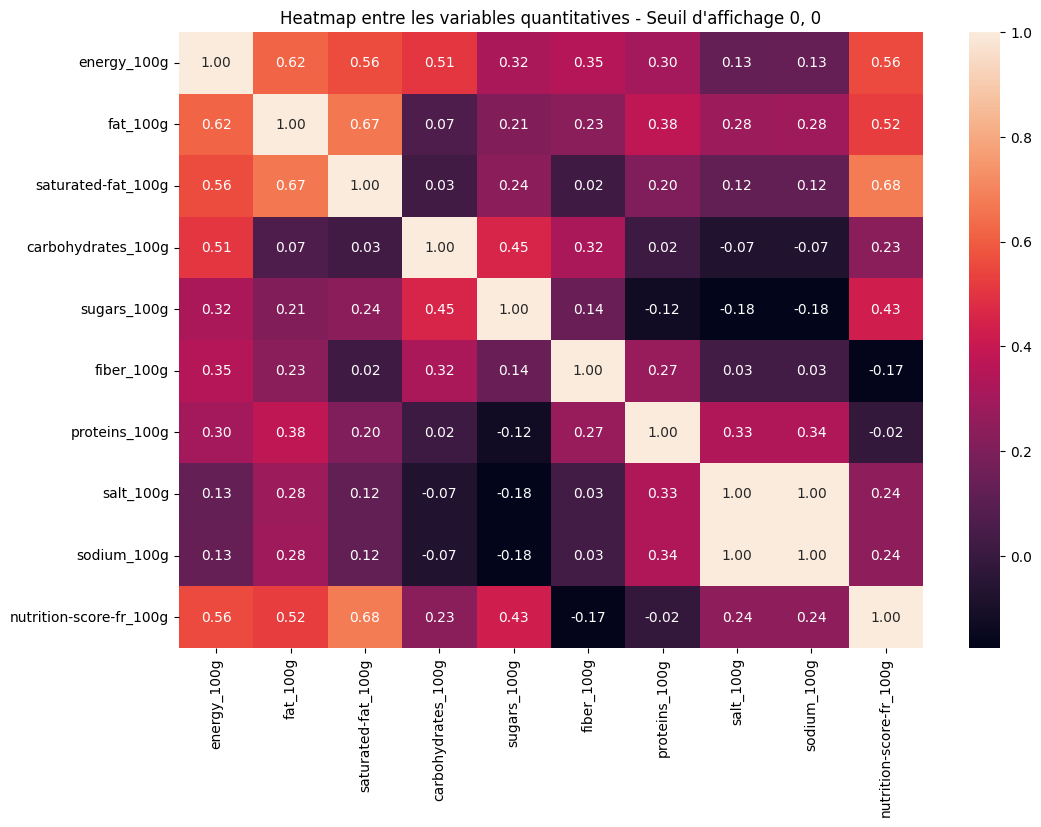

In [340]:
def analyze_uni_multi(df):
    # columns_to_keep,_,_=select_columns()
    data_to_display = df

    quantitative_features,qualitative_features=split_features(data_to_display)
    # display(HTML('<h3>Analyse uni-varié</h3>'))
    # target_distribution(data,target)
    # analyze_distribution(data_to_display,quantitative_features)
    # # metrics = calculate_metrics(df,quantitative_features)

    # # for col, info in metrics.items():
    # #     print(f"Pour la colonne '{col}': ")
    # #     print(f"- {info['Mesure choisie']}: {info['Valeur']}")
    # #     print(f"- Écart-type: {info['Écart-type']}")

    # display(HTML('<h3>Analyse bi-variée</h3>'))
    # plot_pairplot(df,quantitative_features)
    # # # plot_boxplot_numeric_categorical(df,quantitative_features, target)
    plot_correlation_heatmap(df,quantitative_features, threshold=0)
    # target_vs_columnToKeep_distribution(data=df, graphType='violon')
analyze_uni_multi(df)

In [324]:
display(HTML('<h2>Analyse en Composantes Principales (ACP)</h2>'))


### Dans l'ordre

1- on determine le premier axe factorielle (Celui qui explique la plus grande part de la variance de données)</br>
2- On trouve la second axe qui explique la plus grande part de variabilité restante (explique la plus grande part de la variance restante)</br>

### Comment on choisis les axes factoriel

1 - Premiere solution on utilise la Elbow method</br>
    - Represente le graphique de la variance expliquée cumulée en fonction du nombre de composantes principales</br>
    - Identifie le point ou l'ajout de composantes supp, n'apporte que peu d'info supp</br>
    - Choisi le nbs de composantes au niveau du coude.</br>

2 - Second solution: La variance expliqué</br>
    - Calcul le % de variance expliqué par chaques composantes principale et par l'ensemble des composantes selectionnées.</br>
    - Choisi un nbs de composantes qui explique un % satisfaisant de la variance totale</br>

#### ACP

In [325]:
df.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr'],
      dtype='object')

In [347]:
df['energy_100g'].max()

np.float64(3619.0)

In [362]:
# Séparation des données en variables explicatives (X) et variable qualitative (Y)
df_temp=df.copy()
# df_temp['log_energy_100g'] = np.log1p(df['energy_100g'])
df_temp['energy_100g'] = df['energy_100g'] / (df['energy_100g'].max()/100)

x=df_temp.select_dtypes(include=[float, int])
# x=df.select_dtypes(include=[float, int])
y=df[target].values

In [363]:
x.isna().sum()

energy_100g                0
fat_100g                   0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
salt_100g                  0
sodium_100g                0
nutrition-score-fr_100g    0
dtype: int64

In [364]:
# Standardisation des données
scaler=StandardScaler()

# Normaliser les données
x_scaled = scaler.fit_transform(x)

In [365]:
# Réduction de dimension

pca =PCA()

x_pca=pca.fit_transform(x)

### Choix du nombre de composantes factoriels (nombre d'axes)

In [366]:
# Analyse des valeurs propres
n_components = len(pca.explained_variance_)  # Longueur des valeurs propres

comp = pd.DataFrame(
    {
        "Dimension": ["Dim" + str(x + 1) for x in range(n_components)],
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "%\ cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_)*100)
    },
    columns= ["Dimension", "Valeur propre", "% variance expliquée","%\ cum. var. expliquée"]

)
comp


,Dimension,Valeur propre,% variance expliquée,%\ cum. var. expliquée
0,Dim1,880.462088,61.0,61.0
1,Dim2,313.035592,22.0,82.0
2,Dim3,140.228980,10.0,92.0
3,Dim4,49.581906,3.0,96.0
4,Dim5,38.290060,3.0,98.0
5,Dim6,18.463190,1.0,99.0
6,Dim7,5.979394,0.0,100.0
7,Dim8,2.032470,0.0,100.0
8,Dim9,0.365784,0.0,100.0
9,Dim10,0.000518,0.0,100.0


Text(6.5, 13, '12.5%')

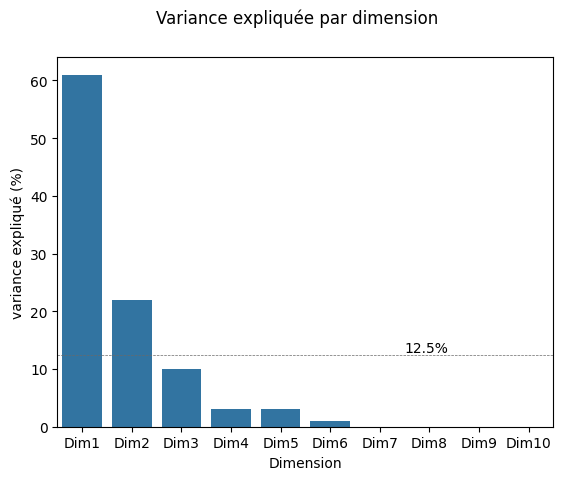

In [367]:
# Scree plot pour choisir le nombre de composantes principales
g_comp = sns.barplot(x= "Dimension",
                     y= "% variance expliquée",
                     data=comp)
g_comp.set(ylabel = "variance expliqué (%)")
g_comp.figure.suptitle("Variance expliquée par dimension")
plt.axhline(y=12.5, linewidth= .5, color ="dimgray", linestyle ="--") # 12.5 = 100 / 8 (nb dimensions)
plt.text(6.5,13,"12.5%")

### On vérifie la qualité de représentation des variables</br>
Si $ \cos^2 $ d'un individu est supérieur à 0.5 sur un axe principal, cela signifie que cet axe représente bien l'individu

In [368]:
x.shape[1]

10

In [369]:
# Calcul du cosinus carré des variables
cos_squared = np.square(pca.components_)

# Création d'un dataframe pandas avec le cosinus carré des variables

df_cos_squared = pd.DataFrame(cos_squared, columns=['PC{}'.format(i+1) for i in range(x.shape[1])])
df_cos_squared.index = df.select_dtypes(include=[float,int]).columns
#df_cos_squared = df_cos_squared[['PC1', 'PC2', 'PC3']]
print(df_cos_squared)

                                  PC1           PC2           PC3  \
energy_100g              2.600499e-01  1.573271e-02  1.697667e-03   
fat_100g                 4.203765e-01  2.173198e-01  2.515505e-02   
saturated-fat_100g       5.764581e-02  5.035606e-03  3.207147e-03   
carbohydrates_100g       2.386776e-01  6.419926e-01  7.815668e-03   
sugars_100g              1.457499e-02  1.175228e-02  3.172461e-02   
fiber_100g               5.840423e-03  9.499917e-02  1.267229e-02   
proteins_100g            1.553134e-03  1.081611e-02  9.136442e-01   
salt_100g                1.223549e-03  2.169508e-03  4.522364e-05   
sodium_100g              5.802287e-05  1.822271e-04  4.038155e-03   
nutrition-score-fr_100g  5.897994e-11  1.368398e-11  1.540621e-08   

                                  PC4           PC5           PC6  \
energy_100g              6.434566e-01  6.312903e-02  5.069710e-04   
fat_100g                 2.760775e-01  2.233578e-04  4.704153e-05   
saturated-fat_100g       3.137147

### On vérifie la contribution des variables à la formation de l'axe</br>
Cela indique l'importance relative de chaque variable pour expliquer la variabilité des données sur un axe principal donnée

In [370]:
# Contribution à la formation de l'axe
# Obtenir les composantes principales
components = np.square(pca.components_)

n_components = x.shape[1]
feature_names=df.select_dtypes(include=[float,int]).columns[0:n_components]

# Calcule la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2) * eigenvalues

# Créé un DataFrame pour faciliter l'affichage des résultats
column_names = [f'PC{i+1}_contrib' for i in range(n_components)]
variable_contrib_df= pd.DataFrame(variable_contributions, columns=column_names, index=feature_names)

print(variable_contrib_df)


                          PC1_contrib  PC2_contrib  PC3_contrib  PC4_contrib  \
energy_100g              2.289641e+02   131.592821     8.083613    11.834091   
fat_100g                 1.385205e+01    68.028833     0.706138    31.831216   
saturated-fat_100g       1.494732e+00     7.874425     0.449735     0.387516   
carbohydrates_100g       5.665391e+02    86.422090     4.399189     2.162838   
sugars_100g              5.558272e+01     0.069919   117.276395     0.970767   
fiber_100g               4.463687e-01     0.014726     0.067653     0.009943   
proteins_100g            4.224949e-01     3.638347     2.445666     2.155326   
salt_100g                8.282569e-06     0.034768     0.013317     0.027782   
sodium_100g              2.740782e-07     0.005400     0.002116     0.004296   
nutrition-score-fr_100g  1.316052e+01    15.354264     6.785159     0.198131   

                         PC5_contrib  PC6_contrib  PC7_contrib  PC8_contrib  \
energy_100g                 0.558077    

#### Calcul normaliser pour une meilleur interprétation

In [371]:
# Calcule la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions =(loadings**2) *eigenvalues

# Converti en %
variable_contrib_percent= variable_contributions / eigenvalues * 100

# Créé un DataFrame pour faciliter l'affichage des résultats
column_names=[f'PC{i+1}_contrib' for i in range(n_components)]
variable_contrib_df=pd.DataFrame(variable_contrib_percent,columns=column_names,index=feature_names)

print(variable_contrib_df)

                          PC1_contrib  PC2_contrib  PC3_contrib  PC4_contrib  \
energy_100g              2.600499e+01    42.037655     5.764581    23.867762   
fat_100g                 1.573271e+00    21.731980     0.503561    64.199259   
saturated-fat_100g       1.697667e-01     2.515505     0.320715     0.781567   
carbohydrates_100g       6.434566e+01    27.607752     3.137147     4.362152   
sugars_100g              6.312903e+00     0.022336    83.632067     1.957905   
fiber_100g               5.069710e-02     0.004704     0.048244     0.020054   
proteins_100g            4.798558e-02     1.162279     1.744051     4.347000   
salt_100g                9.407071e-07     0.011107     0.009496     0.056032   
sodium_100g              3.112890e-08     0.001725     0.001509     0.008664   
nutrition-score-fr_100g  1.494729e+00     4.904958     4.838628     0.399603   

                         PC5_contrib  PC6_contrib  PC7_contrib  PC8_contrib  \
energy_100g                 1.457499    

les individus ayant une contribution supérieure à la contribution moyenne (100 % / nombre d'individus) sont considéré comme étant importants pour la formation de l'axe principal considéré.

#### Calcul pour la contribution des indivdus

In [372]:
# Calcule la contribution des individus à la formation des axes
eigenvalues=pca.explained_variance_
contributions = (x_pca**2) / (x_pca.shape[0] * eigenvalues)

# Converti les contributions en pourventage
contrib_percent = contributions *100

# Créé un DataFrame pour faciliter l'affichage des résultats
column_names=[f'PC{i+1}_contrib' for i in range(n_components)]
contrib_df = pd.DataFrame(contrib_percent, columns=column_names)

print(contrib_df)

         PC1_contrib   PC2_contrib   PC3_contrib   PC4_contrib   PC5_contrib  \
0       1.860213e-09  9.321539e-09  3.659957e-07  1.016641e-07  3.749999e-06   
1       7.308482e-04  1.737746e-04  1.400889e-04  2.270790e-04  1.533530e-06   
2       4.646804e-04  3.609128e-06  1.522560e-04  1.923803e-05  2.625481e-03   
3       4.276719e-05  2.345847e-03  3.945540e-04  1.305730e-04  8.758830e-04   
4       5.626859e-04  4.248952e-04  6.041642e-04  4.821819e-05  1.166781e-05   
...              ...           ...           ...           ...           ...   
320767  1.860213e-09  9.321539e-09  3.659957e-07  1.016641e-07  3.749999e-06   
320768  7.855207e-04  1.207742e-04  1.690220e-07  9.118449e-07  5.138275e-07   
320769  1.860213e-09  9.321539e-09  3.659957e-07  1.016641e-07  3.749999e-06   
320770  1.860213e-09  9.321539e-09  3.659957e-07  1.016641e-07  3.749999e-06   
320771  8.453450e-05  9.866782e-04  2.187891e-04  4.461991e-03  3.319894e-04   

         PC6_contrib   PC7_contrib   PC

### Représentation graphique

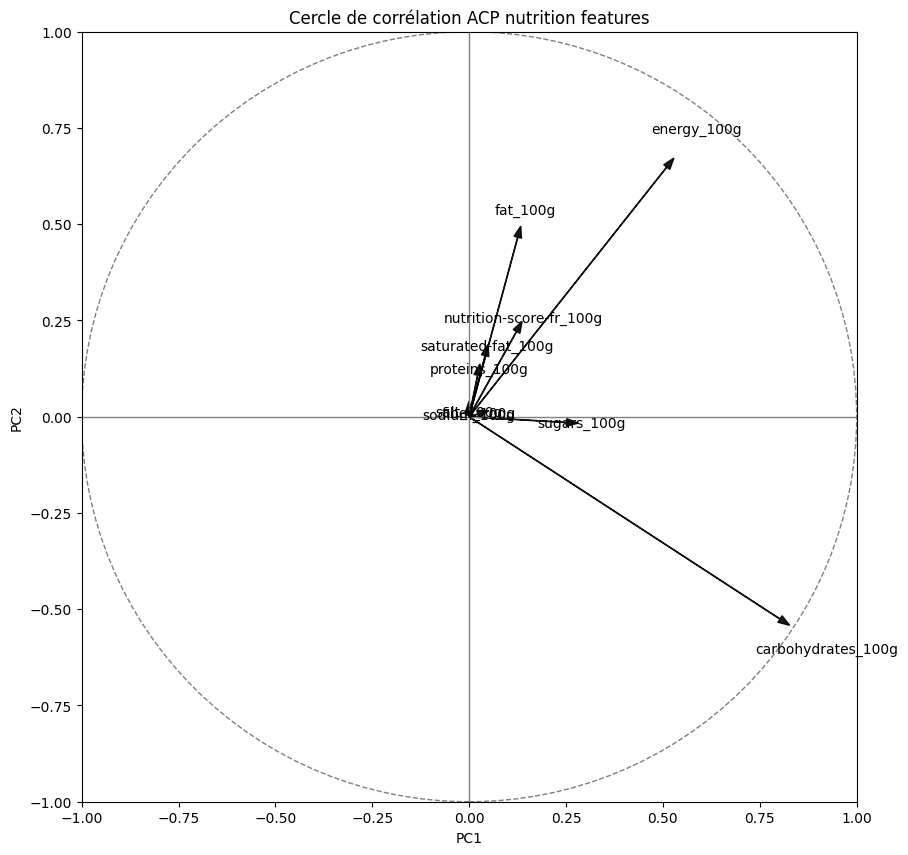

In [373]:
# Creation du cercle des correlation
coeff = np.transpose(pca.components_[0:2,:])
n = coeff.shape[0]
xs = np.array([1,0])
ys = np.array([0,1])

plt.figure(figsize=(10,10))

# Placement des vecteurs des variables
for i in range(n):
    plt.arrow(0,0,coeff[i,0],coeff[i,1], color="k", alpha = 0.9, head_width=0.02)
    plt.text(coeff[i,0] * 1.15, coeff[i,1] * 1.15, feature_names[i], color="k", ha = 'center', va = 'center')

# Placer le cercle unitaire
circle = plt.Circle((0,0),1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP nutrition features')

plt.show()

L'**Analyse en Composantes Principales (ACP)** est une méthode de réduction de dimensionnalité qui vise à simplifier des données complexes tout en conservant autant d'informations que possible. Imagine que tu as un ensemble de variables qui sont peut-être corrélées entre elles (comme les ingrédients dans une recette), et que tu veux les résumer en un plus petit nombre de nouvelles variables (ou **composantes principales**), tout en gardant l'essence des informations.

### Comprendre la PCA à travers une métaphore :
Imagine que tu veux résumer plusieurs types de fruits (les variables originales), et tu essayes de les classer selon deux caractéristiques principales : **leur taille** et **leur couleur**. Avec l'ACP, tu vas essayer de réduire plusieurs caractéristiques (comme le poids, la texture, la douceur) à un plus petit nombre de **composantes principales** comme **taille** et **couleur**, qui sont les plus pertinentes pour expliquer la différence entre les fruits. Ces nouvelles composantes sont appelées **PC1**, **PC2**, etc., et elles expliquent la majorité de l'information.

Maintenant, comment choisir entre **PC1**, **PC2**, etc. pour représenter l’information ? C’est là qu’intervient ton **Scree Plot** (graphique de l’éboulis) que tu as généré.

---

### Interprétation de ton **Scree Plot** :
- Le **Scree Plot** que tu as généré montre combien chaque composante principale (Dim1, Dim2, etc.) explique la variance dans tes données (la variance est un indicateur de la quantité d'information). 
- **PC1** (Dim1) explique environ **40% de la variance** totale (c'est donc la composante la plus importante). 
- **PC2** (Dim2) explique environ **30% de la variance**. 
- Les composantes suivantes (Dim3, Dim4, etc.) expliquent moins de variance et deviennent de moins en moins significatives.

La règle générale est de retenir les composantes qui expliquent ensemble une grande partie de la variance (généralement autour de **70-80%**). Dans ton cas, **PC1 et PC2** expliquent ensemble environ **70% de la variance** (40% + 30%), ce qui est souvent suffisant pour avoir une bonne représentation des données.

---

### Comment choisir quelles composantes afficher dans le **cercle de corrélation** :
Le **cercle de corrélation** permet de visualiser comment les variables d'origine contribuent à la formation des axes (les composantes principales). Le choix de **PC1** et **PC2** dans ton cercle de corrélation est logique car ce sont les composantes qui expliquent le plus de variance, et donc le plus d'information sur les données.

1. **PC1 et PC2** : En général, on commence toujours par afficher **PC1** et **PC2**, car ce sont les axes qui contiennent le plus d'informations. En représentant ces deux composantes, tu captes déjà environ 70% de l’information.
   
2. **PC3, PC4, etc.** : Si **PC1** et **PC2** ne capturent pas assez d'information ou si tu veux explorer d'autres aspects des données, tu peux aussi afficher des combinaisons comme **PC2 vs PC3**, ou **PC1 vs PC3**. Mais dans ton cas, **PC1 et PC2** devraient suffire.

---

### Explication des principales étapes dans ton code :

1. **Scree Plot** : Tu utilises le **Scree Plot** pour identifier les composantes les plus importantes, ici **PC1 et PC2**. Ces composantes expliquent la majorité de la variance, donc tu les choisis pour les représenter dans ton cercle de corrélation.

2. **Cosinus carré** (cos²) : Le **cosinus carré** des variables te permet de voir la contribution de chaque variable (les caractéristiques originales) aux axes principaux. Un **cos² élevé** indique que la variable est bien représentée par l'axe correspondant. Cela t’aide à comprendre quelles variables contribuent le plus à chaque composante principale.

3. **Cercle de corrélation** : Ce graphique montre comment chaque variable est projetée sur les deux premiers axes (PC1 et PC2). Les flèches dans ce graphique représentent chaque variable, et la direction/longueur de la flèche indique combien la variable contribue à la composante. Plus une flèche est proche du bord du cercle, plus la variable est fortement corrélée avec cet axe.

---

### Récapitulatif des étapes pour choisir les bonnes composantes à afficher :
1. Utilise le **Scree Plot** pour déterminer combien de variance est expliquée par chaque composante principale. Dans ton cas, **PC1** et **PC2** expliquent environ 70%, ce qui est souvent suffisant.
2. Visualise ensuite ces deux composantes dans le **cercle de corrélation** pour voir quelles variables d'origine (features) sont le mieux représentées par ces axes.
3. Si nécessaire, tu peux explorer d'autres combinaisons (par exemple **PC2 vs PC3**) si tu veux creuser davantage les relations entre les variables.


In [374]:
df_anova = df.copy()
df_anova.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr'],
      dtype='object')

In [375]:
target

'nutrition_grade_fr'

In [376]:
df_anova[target]= df_anova[target].astype('category')
df_anova.columns = df_anova.columns.str.replace('-','_')

variable_explicatives = df_anova.drop(columns=target)
# columns_to_keep,negative_elements,positive_elements=select_columns()
# variable_explicatives=[]
# for col in positive_elements:
#     variable_explicatives.append(col)
# for col in negative_elements:
#     variable_explicatives.append(col)

# variable_explicatives=[col.replace('-','_') for col in variable_explicatives]

for variable in variable_explicatives.columns:
    formula = f'{variable} ~ C({target})'
    print(f"Formule utilisée : {formula}")


    # Ajustement du model OLS
    model = ols(formula, data=df_anova).fit()

    # Réalisation de l'anova
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Affichage des résultats
    print(f"ANOVA pour {variable}")
    print(anova_table)
    print("\n")

Formule utilisée : energy_100g ~ C(nutrition_grade_fr)
ANOVA pour energy_100g
                             sum_sq        df             F  PR(>F)
C(nutrition_grade_fr)  4.513286e+10       4.0  31472.999593     0.0
Residual               1.149964e+11  320767.0           NaN     NaN


Formule utilisée : fat_100g ~ C(nutrition_grade_fr)
ANOVA pour fat_100g
                             sum_sq        df             F  PR(>F)
C(nutrition_grade_fr)  8.611183e+06       4.0  23960.625231     0.0
Residual               2.882002e+07  320767.0           NaN     NaN


Formule utilisée : saturated_fat_100g ~ C(nutrition_grade_fr)
ANOVA pour saturated_fat_100g
                             sum_sq        df            F  PR(>F)
C(nutrition_grade_fr)  2.344208e+06       4.0  59729.29831     0.0
Residual               3.147302e+06  320767.0          NaN     NaN


Formule utilisée : carbohydrates_100g ~ C(nutrition_grade_fr)
ANOVA pour carbohydrates_100g
                             sum_sq        df      

Si la PR (P-value) est inferieur à 5 % on rejette la valeur null H0.</br>
Donc on sais qu'au moins une paire a une différence significative dans la moyenne. Mais on ne sais pas quelle paire a une différence significative .
il existe un test pour connaitre cette pair.

### Test de student

In [377]:
# Pour chaque variable explicative
for variable in variable_explicatives:
    formula = f'{variable} ~ C({target})'
    model = ols(formula, data=df_anova).fit()
    pair_t = model.t_test_pairwise('C(nutrition_grade_fr)')
    print(f"Comparaisons pairwise pour {variable}:")
    print(pair_t.result_frame)
    print("\n")

Comparaisons pairwise pour energy_100g:
            coef   std err           t  P>|t|  Conf. Int. Low  \
b-a  -227.701304  4.461653  -51.035190    0.0     -236.446016   
c-a   299.056328  4.042162   73.984245    0.0      291.133806   
d-a   551.771754  4.467591  123.505419    0.0      543.015402   
e-a   894.564004  4.259040  210.038907    0.0      886.216409   
c-b   526.757632  3.136124  167.964559    0.0      520.610919   
d-b   779.473057  3.668183  212.495668    0.0      772.283523   
e-b  1122.265308  3.411101  329.003794    0.0     1115.579647   
d-c   252.715425  3.144566   80.365745    0.0      246.552165   
e-c   595.507676  2.840483  209.650162    0.0      589.940411   
e-d   342.792251  3.418865  100.264921    0.0      336.091373   

     Conf. Int. Upp.  pvalue-hs  reject-hs  
b-a      -218.956592        0.0       True  
c-a       306.978851        0.0       True  
d-a       560.528105        0.0       True  
e-a       902.911600        0.0       True  
c-b       532.90434

## A FAIRE
Histplot nutrition grade a,b,c... sur x et quantité sur y</br>
Analyse bi-variée</br>
    - NG vs ...</br>
ACP</br>
Anova

Valeur impossible si > 100 = nan
saturated fat > fat impossible = nan